## All Imports

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchtext.vocab import FastText
import spacy 

import pandas as pd 
import re 
from collections import Counter
import torch 
from torch.utils.data import DataLoader, Dataset 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt 
import torch.optim as optim 

## Load Spacy and FastText

In [2]:
nlp = spacy.load("en_core_web_sm") 
fasttext = FastText("simple") 

## Read and Preprocess Data 

In [3]:
data = pd.read_csv('data/train.csv')
data = data.drop('id', axis=1)

In [4]:
def preprocessing(data):
    data['comment_text'] = data['comment_text'].apply(lambda text: text.lower()) 
    data['comment_text'] = data['comment_text'].apply(lambda text: text.strip()) 
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('\n', ' ', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('\'', '', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('"', '', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('" ', '', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub(' "', '', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('-', ' ', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('=', ' ', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub('\w*\d\w*\*', ' ', text))
    data['comment_text'] = data['comment_text'].apply(lambda text: re.sub(r'[^\x00-\x7f]', r' ', text)) 
    data['comment_text'] = data['comment_text'].apply(lambda text: text.strip())
    return data 

data = (preprocessing(data))

In [6]:
print(len(data))
print(data.shape)

159571
(159571, 7)


## Shuffle Data

In [7]:
def shuffle_data(dataset):
    return dataset.sample(frac=1).reset_index(drop=True)

data = shuffle_data(data)

In [8]:
def data_engineering(data):
    column_name, no, yes = [], [], []
    for i in data.columns:
        if i == 'comment_text':
            continue
        else:
            column_name.append(i),   no.append(data[i].value_counts()[0]),   yes.append(data[i].value_counts()[1])
    return column_name, no, yes 

## Split Data

In [9]:
def split_data(data):
    data_toxic          = data[['comment_text', 'toxic']]
    data_severe_toxic   = data[['comment_text', 'severe_toxic']]
    data_obscene        = data[['comment_text', 'obscene']]
    data_threat         = data[['comment_text', 'threat']]
    data_insult         = data[['comment_text', 'insult']]
    data_identity_hate  = data[['comment_text', 'identity_hate']]
    return data_toxic, data_severe_toxic, data_obscene, data_threat, data_insult, data_identity_hate 

data_toxic, data_severe_toxic, data_obscene, data_threat, data_insult, data_identity_hate = split_data(data)

## Build Model

In [10]:
class ToxicClassifier(nn.Module):
     def __init__(self, max_seq_len=32, emb_dim=300, hidden=64):
          super(ToxicClassifier, self).__init__()
          self.input_layer   = nn.Linear(max_seq_len*emb_dim, hidden)
          self.first_hidden  = nn.Linear(hidden, hidden)
          self.second_hidden = nn.Linear(hidden, hidden)
          self.third_hidden  = nn.Linear(hidden, hidden)

          self.output = nn.Linear(hidden, 6)
          
          self.sigmoid    = nn.Sigmoid()


     def forward(self, inputs):
          x = F.relu(self.input_layer(inputs.squeeze(1).float()))

          x = F.relu(self.first_hidden(x))
          x = F.relu(self.first_hidden(x))
          x = F.relu(self.second_hidden(x))
          x = F.relu(self.third_hidden(x))

          output = self.output(x)

          return output

## Preprocess Functions

In [11]:
def token_encoder(token, vec):
    if token == "<pad>":
        return 1
    else:
        try:
            return vec.stoi[token]
        except:
            return 0

In [12]:
def encoder(tokens, vec):
    return [token_encoder(token, vec) for token in tokens]

In [13]:
def front_padding(list_of_indexes, max_seq_len, padding_index=0):
    new_out = (max_seq_len - len(list_of_indexes))*[padding_index] + list_of_indexes
    return new_out[:max_seq_len] 

In [14]:
def preprocessing(sentence):
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return tokens

## Dataset and DataLoader

In [18]:
max_seq_length = 50

class TrainData(Dataset):
    def __init__(self, data, data_target, max_seq_len=max_seq_length): # data is the input data, max_seq_len is the max lenght allowed to a sentence before cutting or padding
        self.max_seq_len = max_seq_len
        
        counter = Counter()
        train_iter = iter(data['comment_text'].values)
        self.vec = FastText("simple")

        self.vec.vectors[1] = -torch.ones(self.vec.vectors[1].shape[0]) # replacing the vector associated with 1 (padded value) to become a vector of -1.
        self.vec.vectors[0] = torch.zeros(self.vec.vectors[0].shape[0]) # replacing the vector associated with 0 (unknown) to become zeros
        self.vectorizer = lambda x: self.vec.vectors[x]

        self.target = data[data_target]
        features = [front_padding(encoder(preprocessing(sequence), self.vec), max_seq_len) for sequence in data['comment_text'].tolist()]
        self.features = features
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, i):
        assert len(self.features[i]) == self.max_seq_len
        return self.features[i], self.target[i]

## Inputs

In [19]:
length_of_data = 159571 
max_seq_length = 64 
idx = int(0.7 * length_of_data)

## Datasets and DataLoader

In [20]:
columns_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_toxic, data_severe_toxic, data_obscene, data_threat, data_insult, data_identity_hate = split_data(data)  

train_data_toxic = data_toxic.iloc[ : 2000 ].reset_index(drop=True)
test_data_toxic  = data_toxic.iloc[2000 : 3000 ].reset_index(drop=True)

dataset_train = TrainData(train_data_toxic, data_target='identity_hate', max_seq_len=max_seq_length)
dataset_test  = TrainData(test_data_toxic,  data_target='identity_hate', max_seq_len=max_seq_length)

## Collation

In [21]:
def collation_train(batch, vectorizer=dataset_train.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch]) 
    return inputs, target

def collation_test(batch, vectorizer=dataset_test.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch]) 
    return inputs, target

train_loader = DataLoader(dataset_train, batch_size=32, collate_fn=collation_train)
test_loader  = DataLoader(dataset_test,  batch_size=32, collate_fn=collation_test)

## Model, Loss Function, and Activation Function

In [22]:
emb_dim = 300

model = ToxicClassifier(max_seq_len=max_seq_length, emb_dim=emb_dim, hidden=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## Training

In [23]:

epochs = 30
all_train_losses, all_test_losses, all_accuracies = [],  [], []

for e in range(epochs):
     train_losses, test_losses, running_accuracy = 0, 0, 0

     for i, (sentences_train, labels_train) in enumerate(iter(train_loader)):
          # print(sentences_train.shape)
          sentences_train.resize_(sentences_train.size()[0], max_seq_length * emb_dim)

          optimizer.zero_grad()
          prediction_train = model.forward(sentences_train)   
          loss_train = criterion(prediction_train, labels_train) 
          loss_train.backward()                  
          optimizer.step()                

          train_losses += loss_train.item()
     
     avg_train_loss = train_losses/len(train_loader)
     all_train_losses.append(avg_train_loss)


     model.eval()
     with torch.no_grad():
          for i, (sentences_test, labels_test) in enumerate(iter(test_loader)):
               sentences_test.resize_(sentences_test.size()[0], max_seq_length * emb_dim)

               prediction_test = model.forward(sentences_test) 
               loss_test = criterion(prediction_test, labels_test) 

               test_losses += loss_test.item()


               prediction_class = torch.argmax(prediction_test, dim=1)
               running_accuracy += accuracy_score(labels_test, prediction_class)
          
          avg_test_loss = test_losses/len(test_loader)
          all_test_losses.append(avg_test_loss)

          avg_running_accuracy = running_accuracy/len(test_loader)
          all_accuracies.append(avg_running_accuracy)


     model.train()


     print(f'Epoch  : {e+1:3}/{epochs}    |   Train Loss:  : {avg_train_loss:.8f}     |  Test Loss:  : {avg_test_loss:.8f}  |  Accuracy  :   {avg_running_accuracy:.4f}')

torch.save({ "model_state": model.state_dict(), 'max_seq_len' : 64, 'emb_dim' : 64, 'hidden1' : 32, 'hidden2' : 32}, 'trained_models/trained_model_TOXIC')



Epoch  :   1/30    |   Train Loss:  : 0.39339850     |  Test Loss:  : 0.06110165  |  Accuracy  :   0.9922
Epoch  :   2/30    |   Train Loss:  : 0.05531279     |  Test Loss:  : 0.05237641  |  Accuracy  :   0.9922
Epoch  :   3/30    |   Train Loss:  : 0.02891417     |  Test Loss:  : 0.05465348  |  Accuracy  :   0.9922
Epoch  :   4/30    |   Train Loss:  : 0.00443527     |  Test Loss:  : 0.09936310  |  Accuracy  :   0.9912
Epoch  :   5/30    |   Train Loss:  : 0.00163278     |  Test Loss:  : 0.11759304  |  Accuracy  :   0.9912
Epoch  :   6/30    |   Train Loss:  : 0.00127468     |  Test Loss:  : 0.13349925  |  Accuracy  :   0.9912
Epoch  :   7/30    |   Train Loss:  : 0.00107359     |  Test Loss:  : 0.15706843  |  Accuracy  :   0.9922
Epoch  :   8/30    |   Train Loss:  : 0.00123596     |  Test Loss:  : 0.14293428  |  Accuracy  :   0.9912
Epoch  :   9/30    |   Train Loss:  : 0.00103215     |  Test Loss:  : 0.17126348  |  Accuracy  :   0.9922
Epoch  :  10/30    |   Train Loss:  : 0.000939

## Plot Training Results

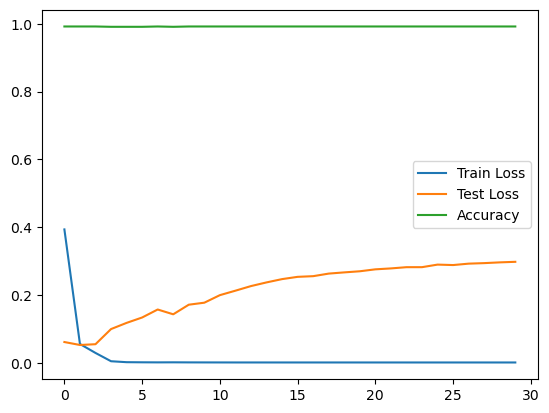

In [24]:
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_test_losses,  label='Test Loss')
plt.plot(all_accuracies,   label='Accuracy')

plt.legend()
plt.show() 

## Predictions

In [42]:
import torch 
from helper_functions import ToxicClassifier, token_encoder, encoder, front_padding, preprocessing, nlp, fasttext
import numpy as np 

max_seq_length, emb_dim = 64, 300
model = ToxicClassifier()

train_modeled = torch.load('trained_models/trained_all_model')
model_state = train_modeled['model_state']
model = ToxicClassifier(max_seq_len=max_seq_length, emb_dim=emb_dim, hidden=64)
model.load_state_dict(model_state)


comment = 'Do something about him. He constantly blames me of vandalism, even though I have not done such.  See the current version of the Battle of Budapest article.'
comment = 'The WaPo article says, in effect, that a Fed hate crime prosecution would require a racial motivation, but if Brown had been white shooting at him when fleeing would still have been an intentional attempt to deprive him of his civil rights, per Garner. Are you saying there is no Federal statute that allows the DOJ to prosecute him for this, despite the Constitutional violation?'
comment = "He said he's WORKING ON IT, The Rouge Penguin, have some patience, Don't be an asshole."


features = front_padding(encoder(preprocessing(comment), fasttext), max_seq_length) 

embeddings = [fasttext.vectors[el] for el in features]

inputs = torch.stack(  embeddings )


model.eval()
with torch.no_grad():
    prediction = model.forward(inputs.flatten().unsqueeze(1))
    probability_test = torch.sigmoid(prediction)
    classes = probability_test > 0.5

pred = np.array(classes)
    

toxic, severe_toxic, obscene, threat, insult, identity_hate, space = 'TOXIC', 'SEVERE_TOXIC', 'OBSCENE', 'THREAT', 'INSULT', 'IDENTITY_HATE', '---------------'

print(f'{toxic:15}|{severe_toxic:15}|{obscene:15}|{threat:15}|{insult:15}|{identity_hate}')
print(f"{space:15}|{space:15}|{  space:15}|{  space:15}|{  space:15}|{  space:15}")
print(f"{str(pred[0]):15}|{str(pred[1]):15}|{  str(pred[2]):15}|{  str(pred[3]):15}|{  str(pred[4]):15}|{  str(pred[5]):15}")

TOXIC          |SEVERE_TOXIC   |OBSCENE        |THREAT         |INSULT         |IDENTITY_HATE
---------------|---------------|---------------|---------------|---------------|---------------
False          |False          |False          |False          |False          |False          
